In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Summary

    * sklearn DBSCAN algorithm
    
    * min_samples, $\epsilon$ and distance metric as the hyperparameters.
    
    * The charge and type predictors of the data not used in the learning process.
    
    * Scaler for data used is MinMaxScaler.
    
    * See KMeans notebook for more information.
    
    * Results: 
        1. 2 clusters with outliers. 
        
        2. No common charge/type combination between the clusters.
        
        3. The combinations with same charges, i.e. 1,1 and -1,-1, but with types (EE,EE) and (EE,EB) seem to have a high fraction of outliers.
        
        4. See at the end of the notebook.

In [2]:
import numpy as np
import pandas as pd
import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [3]:
import jupyterthemes as jt
jt.jtplot.style(theme = 'grade3', context = 'paper', ticks=True, grid = False)

In [4]:
from plot_func import plot_func

### Importing Data

In [5]:
import os

In [6]:
dirname = os.getcwd()
dirname

'/home/sameer/Data_Science/Unsupervised_Learning/Unsupervised_ML_of_Z_boson_decay'

In [ ]:
# scaled_data = da.from_npy_stack(dirname, mmap_mode='r') 
# does not work.

In [7]:
scaled_data = np.load('scaled_traindata.npz', allow_pickle=True, mmap_mode='r')
scaled_data.files

['scaled_data', 'arr_names']

In [8]:
scaled_data.get('arr_names')

array(['pt1', 'eta1', 'phi1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1',
       'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'sigmaEtaEta2',
       'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2', 'x0_-1', 'x0_1',
       'x0_EB', 'x0_EE'], dtype=object)

In [9]:
train_data = scaled_data.get('scaled_data')
train_data

array([[0.0553233 , 0.93651436, 0.8267333 , ..., 1.        , 1.        ,
        0.        ],
       [0.04970189, 0.33448867, 0.24761253, ..., 0.        , 1.        ,
        0.        ],
       [0.00426031, 0.36142722, 0.76042529, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.07373313, 0.67250111, 0.2175304 , ..., 0.        , 0.        ,
        1.        ],
       [0.07313911, 0.43377043, 0.02285605, ..., 0.        , 1.        ,
        0.        ],
       [0.06105568, 0.82186664, 0.31306106, ..., 1.        , 0.        ,
        1.        ]])

In [10]:
train_data.shape

(10000, 24)

In [11]:
# Creating a dask array
train_data_dask = da.from_array(train_data, chunks=(100,100), meta = scaled_data.get('arr_names'))

In [19]:
# train_data_dask.visualize(format='dot')

### DBSCAN

    * no DBSCAN implementation in Dask

In [12]:
from sklearn.cluster import DBSCAN

    * Important to remember that high dimension data not conducive for DBSCAN

#### Choosing the hyperparameters: $\epsilon$, distance metric and min_samples

In [13]:
# No dask module
from sklearn.neighbors import NearestNeighbors

    a good starting point for k is 2*dimensions - 1

In [14]:
kneigh = (train_data.shape[1]- 8) * 2 - 1
kneigh

31

    Leaving out the last 8 columns corresponding to the charge and type of the 2 charges.
    
    See KMeans notebook for further details.

In [15]:
nearestneighdist = NearestNeighbors(n_neighbors=kneigh, algorithm='brute', n_jobs=3, metric = 'euclidean')

In [16]:
nearestneighdist.fit(train_data[:,:16])

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=3, n_neighbors=31, p=2, radius=1.0)

In [17]:
dist, points = nearestneighdist.kneighbors(train_data[:,:16], n_neighbors=kneigh, return_distance=True)
dist.shape, points.shape

((10000, 31), (10000, 31))

In [19]:
points[0], dist[0]

(array([   0, 5637, 3514, 5272, 4664,  334, 5917,   19, 7531,  871, 4548,
        1798, 4752, 3350, 6044, 3081, 7035,  891, 8095, 2054, 1611, 3887,
        4431, 5867, 9528, 9195, 1665, 2067, 2801, 3519, 3577]),
 array([0.        , 0.12353493, 0.14887876, 0.15800265, 0.15860192,
        0.16491079, 0.17486896, 0.17961905, 0.18034293, 0.18782834,
        0.18838997, 0.19294611, 0.19364647, 0.20206603, 0.2038469 ,
        0.20483033, 0.2054771 , 0.20745173, 0.20989766, 0.21202627,
        0.21821436, 0.22153248, 0.2227503 , 0.22524385, 0.22962353,
        0.2321459 , 0.23428641, 0.23467525, 0.23623841, 0.23652406,
        0.2370366 ]))

#### Mean of the distances for epsilon

In [21]:
np.argsort([1,3,0,2])

array([2, 0, 3, 1])

In [22]:
sorted_indices_mean = np.argsort(np.apply_along_axis(np.mean, axis=1, arr = dist))

In [23]:
sorted_indices_mean = sorted_indices_mean[::-1]
# sorting in descending order

In [24]:
sorted_dist_mean = dist[sorted_indices_mean]
sorted_points_mean = points[sorted_indices_mean]
sorted_points_mean.shape

(10000, 31)

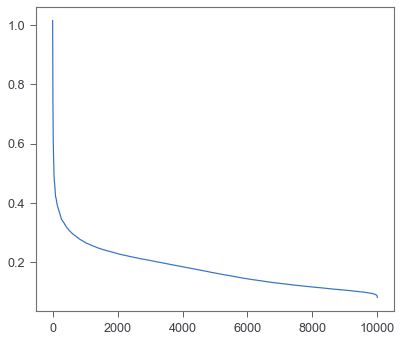

In [25]:
#Plotting mean of the distances
plt.plot(points[:,0], np.apply_along_axis(np.mean, axis=1, arr = sorted_dist_mean))
# plt.xlim([0,577])
plt.show()

    * By eye, eps = 0.3

####  Plotting the gradient of the sorted mean for an estimate of the elbow point

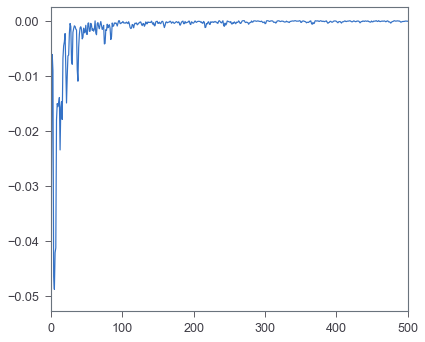

In [26]:
plt.plot(points[:,0], np.gradient(np.apply_along_axis(np.mean, axis=1, arr = sorted_dist_mean)))
plt.xlim([0,500])
plt.show()

    * Around point 60 appears to be the "elbow point".

In [27]:
np.apply_along_axis(np.mean, axis=1, arr = sorted_dist_mean)[60]

0.4651578003564287

#### Choosing the first value estimated by eye  for eps

In [28]:
eps = np.apply_along_axis(np.mean, axis=1, arr = sorted_dist_mean)
eps

array([1.01344449, 0.96314793, 0.95674544, ..., 0.08451077, 0.08414917,
       0.08244103])

In [29]:
eps = eps[eps <=0.3]

In [30]:
eps = eps[0]
eps

0.299952119868314

In [31]:
np.argwhere(eps == np.apply_along_axis(np.mean, axis=1, arr = sorted_dist_mean))

array([[577]])

    * Clearly, this point is very different from the elbow point obtained from the gradient plot.
   

#### Fitting. Using min_samples = 2*dim

In [32]:
dbscan1 = DBSCAN(eps = eps, min_samples = 2*train_data[:,:16].shape[1], metric = 'euclidean', n_jobs=3)

In [33]:
dbscan1_results = dbscan1.fit(train_data[:,:16])

In [34]:
dbscan1_results.core_sample_indices_.shape

(8886,)

In [35]:
np.unique(dbscan1_results.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 277, 4797, 4926]))

    * Two clusters

#### Choosing eps obtained from the gradient plot 

##### Fitting

In [36]:
dbscan2 = DBSCAN(eps = 0.466, min_samples = 2*train_data[:,:16].shape[1], metric = 'euclidean', n_jobs=3)
dbscan2_results = dbscan2.fit(train_data[:,:16])
dbscan2_results.core_sample_indices_.shape, np.unique(dbscan2_results.labels_, return_counts=True)

((9883,), (array([-1,  0]), array([  30, 9970])))

    * Almost all are core points.
    
    So, the best way to choose $\epsilon$ is not using gradient but by drawing two imaginary (or real if you can afford time) straight lines and choosing the value at the point of intersection.

### Varying min_samples

In [37]:
eps

0.299952119868314

#### Varying min_samples from the counts of particle charge/type combination

     Using dask dataframe to get the counts

In [38]:
from decode_fn_v2 import decode_fn_v2

In [39]:
train_data[:,16:24][:5]

array([[1., 0., 0., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 0., 1., 0., 0., 1.]])

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
encoder_charge = OneHotEncoder(categories='auto')
encoded_charge = encoder_charge.fit([[-1],[1]])

In [42]:
encoded_charge.transform([[1],[-1]]).toarray()

array([[0., 1.],
       [1., 0.]])

In [145]:
encoded_type=OneHotEncoder().fit([['EE'], ['EB']])

In [146]:
charge_type_arr = decode_fn_v2(encoded_charge=OneHotEncoder(categories='auto').fit([[-1],[1]]),
             encoded_type=encoded_type, labels=train_data[:,16:24])

In [147]:
charge_type_arr.shape

(10000, 4)

In [45]:
scaled_data.get('arr_names')

array(['pt1', 'eta1', 'phi1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1',
       'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'sigmaEtaEta2',
       'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2', 'x0_-1', 'x0_1',
       'x0_EB', 'x0_EE'], dtype=object)

In [46]:
charge_type_df = dd.from_array(charge_type_arr, columns=['Q1', 'Q2', 'type1', 'type2'])

In [47]:
charge_type_df.head(4)

,Q1,Q2,type1,type2
0,-1,1,EE,EB
1,1,-1,EB,EB
2,-1,1,EB,EE
3,1,-1,EB,EB


In [48]:
charge_type_df = charge_type_df.reset_index()
charge_type_df.head(5)

,index,Q1,Q2,type1,type2
0,0,-1,1,EE,EB
1,1,1,-1,EB,EB
2,2,-1,1,EB,EE
3,3,1,-1,EB,EB
4,4,1,-1,EB,EE


In [253]:
# np.concatenate((train_data[:,:16][:5], decode_fn_v2(encoded_charge=OneHotEncoder(categories='auto').fit([[-1],[1]]),
#              encoded_type=OneHotEncoder().fit([['EE'], ['EB']]), labels=train_data[:,16:24][:5])), axis=1 ).shape

In [49]:
charge_type_df.columns.to_list()

['index', 'Q1', 'Q2', 'type1', 'type2']

In [50]:
groupby_charge_type = charge_type_df.groupby(by = charge_type_df.columns[1:].to_list())

In [51]:
groupby_charge_type.count().compute()

index
Q1 Q2 type1 type2       
-1 -1 EB    EB       523
            EE       327
      EE    EB       154
            EE       170
   1  EB    EB      1946
            EE       918
      EE    EB       402
            EE       462
1  -1 EB    EB      1947
            EE      1028
      EE    EB       417
            EE       471
   1  EB    EB       565
            EE       335
      EE    EB       166
            EE       169

In [52]:
charge_type_counts_df = groupby_charge_type.count().compute()

In [53]:
charge_type_counts_df.values

array([[ 523],
       [ 327],
       [ 154],
       [ 170],
       [1946],
       [ 918],
       [ 402],
       [ 462],
       [1947],
       [1028],
       [ 417],
       [ 471],
       [ 565],
       [ 335],
       [ 166],
       [ 169]])

In [54]:
charge_type_counts =  np.ravel(charge_type_counts_df.values)
charge_type_counts

array([ 523,  327,  154,  170, 1946,  918,  402,  462, 1947, 1028,  417,
        471,  565,  335,  166,  169])

In [55]:
# sorting in ascending order
charge_type_counts = np.sort(charge_type_counts)
charge_type_counts

array([ 154,  166,  169,  170,  327,  335,  402,  417,  462,  471,  523,
        565,  918, 1028, 1946, 1947])

#### Varying min_samples 

In [56]:
eps

0.299952119868314

In [57]:
for i in charge_type_counts:
    dbscan = DBSCAN(eps = eps, min_samples = i, metric = 'euclidean', n_jobs=3)
    dbscan_results = dbscan.fit(train_data[:,:16])
    print('min_samples: ', i, dbscan_results.core_sample_indices_.shape, np.unique(dbscan_results.labels_, return_counts=True))

min_samples:  154 (6663,) (array([-1,  0,  1]), array([ 553, 4787, 4660]))
min_samples:  166 (6481,) (array([-1,  0,  1]), array([ 587, 4769, 4644]))
min_samples:  169 (6438,) (array([-1,  0,  1]), array([ 592, 4766, 4642]))
min_samples:  170 (6419,) (array([-1,  0,  1]), array([ 593, 4765, 4642]))
min_samples:  327 (3898,) (array([-1,  0,  1]), array([1133, 4498, 4369]))
min_samples:  335 (3789,) (array([-1,  0,  1]), array([1171, 4484, 4345]))
min_samples:  402 (2854,) (array([-1,  0,  1]), array([1609, 4263, 4128]))
min_samples:  417 (2649,) (array([-1,  0,  1]), array([1711, 4227, 4062]))
min_samples:  462 (2120,) (array([-1,  0,  1]), array([2062, 4056, 3882]))
min_samples:  471 (2013,) (array([-1,  0,  1]), array([2111, 4026, 3863]))
min_samples:  523 (1467,) (array([-1,  0,  1]), array([2480, 3838, 3682]))
min_samples:  565 (1083,) (array([-1,  0,  1]), array([2909, 3635, 3456]))
min_samples:  918 (0,) (array([-1]), array([10000]))
min_samples:  1028 (0,) (array([-1]), array([10

    * With increasing min_samples, the number of outliers increases and then drops to 0 yielding only 1 cluster.

In [58]:
# with 2*dim number of min_samples
dbscan1.core_sample_indices_.shape, np.unique(dbscan1.labels_, return_counts=True)

((8886,), (array([-1,  0,  1]), array([ 277, 4797, 4926])))

### Silhouette score for evaluating the clustering performance

In [118]:
# For min_samples 
min_samples = [32, 154, 327, 523]
# Silhouette score requires at least 2 labels, so no such value for clusters with only 1 labels

In [91]:
from silhouette_plot import silhouette_plot

In [95]:
from sklearn.metrics import silhouette_score

#### eps: 0.3, min_samples: 32

In [96]:
sil_values = []

In [98]:
sil_values.append(silhouette_score(train_data[:,:16], dbscan1_results.labels_))
sil_values

[0.3238151164322349]

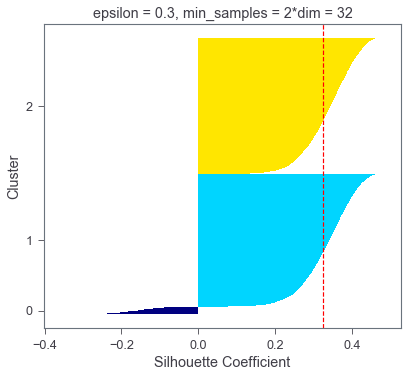

In [92]:
silhouette_plot(train_data[:,:16], dbscan1_results.labels_, title = 'epsilon = 0.3, min_samples = 2*dim = 32')

### To reload a modified module

In [73]:
%load_ext autoreload

In [77]:
%autoreload 2

    Did not work when silhouette_plot was modified

In [80]:
import importlib

In [85]:
import sys

In [90]:
importlib.reload(sys.modules['silhouette_plot'])

<module 'silhouette_plot' from '/home/sameer/Data_Science/Unsupervised_Learning/Unsupervised_ML_of_Z_boson_decay/silhouette_plot.py'>

    Works

#### eps: 0.3, min_samples: 154

In [106]:
min_samples[1]

154

In [125]:
dbscan154 = DBSCAN(eps = eps, min_samples = min_samples[1], metric = 'euclidean', n_jobs=3)
dbscan154_results = dbscan154.fit(train_data[:,:16])

In [99]:
sil_values.append(silhouette_score(train_data[:,:16], dbscan154_results.labels_))
sil_values

[0.3238151164322349, 0.31066407983330147]

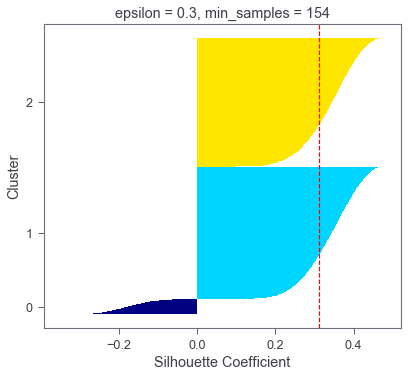

In [94]:
silhouette_plot(train_data[:,:16], dbscan154_results.labels_, title = 'epsilon = 0.3, min_samples = 154')

#### eps: 0.3, min_samples: 327

In [100]:
min_samples[2]

327

In [102]:
dbscan327 = DBSCAN(eps = eps, min_samples = min_samples[2], metric = 'euclidean', n_jobs=3)
dbscan327_results = dbscan327.fit(train_data[:,:16])

In [103]:
sil_values.append(silhouette_score(train_data[:,:16], dbscan327_results.labels_))
sil_values

[0.3238151164322349, 0.31066407983330147, 0.2881555741110308]

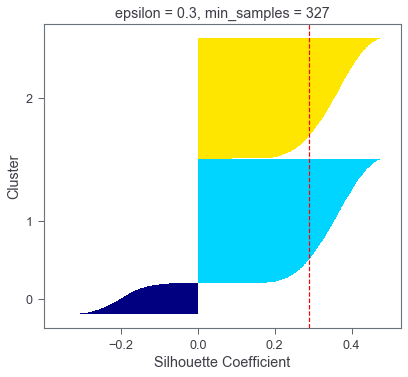

In [105]:
silhouette_plot(train_data[:,:16], dbscan327.labels_, title = 'epsilon = 0.3, min_samples = 327')

#### eps: 0.3, min_samples: 523

In [107]:
min_samples[3]

523

In [108]:
dbscan523 = DBSCAN(eps = eps, min_samples = min_samples[3], metric = 'euclidean', n_jobs=3)
dbscan523_results = dbscan523.fit(train_data[:,:16])

In [113]:
sil_values.append(silhouette_score(train_data[:,:16], dbscan523_results.labels_))
sil_values

[0.3238151164322349,
 0.31066407983330147,
 0.2881555741110308,
 0.22377912678160639]

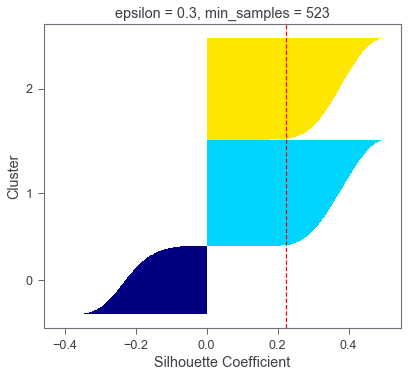

In [114]:
silhouette_plot(train_data[:,:16], dbscan523_results.labels_, title = 'epsilon = 0.3, min_samples = 523')

    The silhouette score decreases by a small value for min_samples from 32 to 154 but by a larger value from 154 to higher numbers.

In [122]:
np.unique(dbscan1_results.labels_, return_counts=True), dbscan1_results.core_sample_indices_.shape

((array([-1,  0,  1]), array([ 277, 4797, 4926])), (8886,))

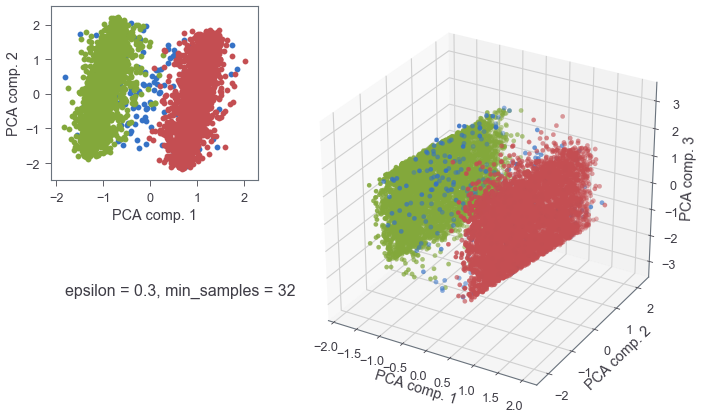

In [130]:
plot_func(train_data[:,:16], dbscan1_results.labels_, text = 'epsilon = 0.3, min_samples = 32')

In [126]:
np.unique(dbscan154_results.labels_, return_counts=True), dbscan154_results.core_sample_indices_.shape

((array([-1,  0,  1]), array([ 553, 4787, 4660])), (6663,))

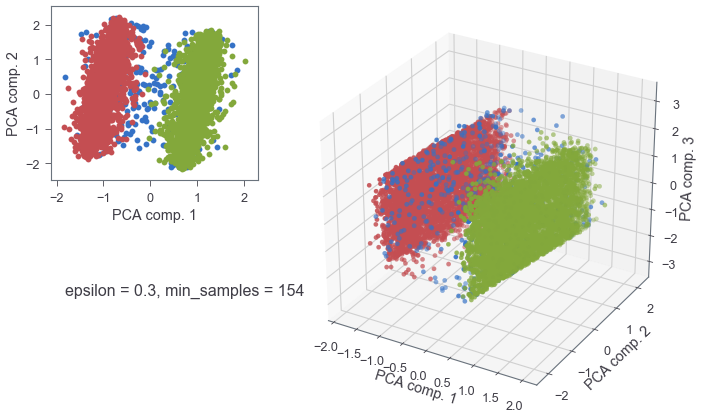

In [131]:
plot_func(train_data[:,:16], dbscan154_results.labels_, text = 'epsilon = 0.3, min_samples = 154')

In [127]:
np.unique(dbscan327_results.labels_, return_counts=True), dbscan327_results.core_sample_indices_.shape

((array([-1,  0,  1]), array([1133, 4498, 4369])), (3898,))

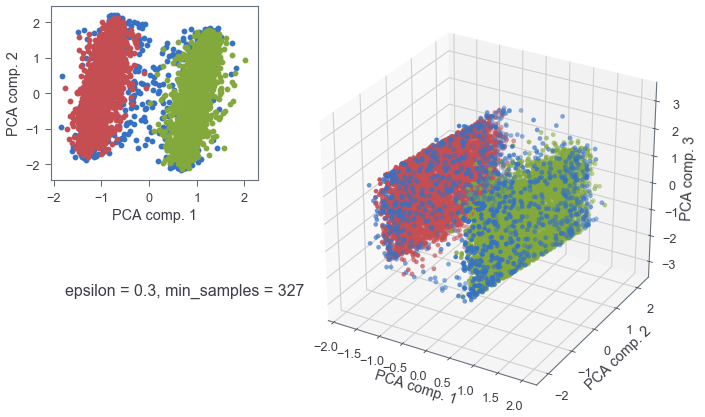

In [132]:
plot_func(train_data[:,:16], dbscan327_results.labels_, text = 'epsilon = 0.3, min_samples = 327')

In [128]:
np.unique(dbscan523_results.labels_, return_counts=True), dbscan523_results.core_sample_indices_.shape

((array([-1,  0,  1]), array([2480, 3838, 3682])), (1467,))

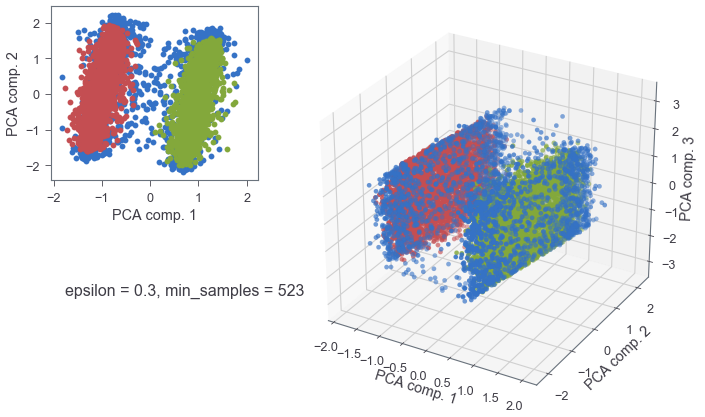

In [133]:
plot_func(train_data[:,:16], dbscan523_results.labels_, text = 'epsilon = 0.3, min_samples = 523')

     Examining the PCA plots, the optimal value for min_samples is 154 (can be further finetuned).


     Therefore, the clustering results are the ones obtaining with the following hyperparameters
         1. eps = 0.3
         2. min_samples = 154
         3. distance = Euclidean

    Since BDSCAN is a deterministic algorithm, the fit with the hyperparameters should be carried out using shuffled training data to check for consistent results.

In [135]:
train_data_copy = train_data.copy()

In [138]:
dbscan = DBSCAN(eps = eps, min_samples=154, metric='euclidean', n_jobs=3)
for _ in range(5):
    np.random.shuffle(train_data_copy)
    dbscan_results =  dbscan.fit(train_data_copy[:,:16])
    print(np.unique(dbscan_results.labels_, return_counts=True), dbscan_results.core_sample_indices_.shape)

(array([-1,  0,  1]), array([ 553, 4787, 4660])) (6663,)
(array([-1,  0,  1]), array([ 553, 4662, 4785])) (6663,)
(array([-1,  0,  1]), array([ 553, 4662, 4785])) (6663,)
(array([-1,  0,  1]), array([ 553, 4662, 4785])) (6663,)
(array([-1,  0,  1]), array([ 553, 4662, 4785])) (6663,)


    The results are consistent.

### Searching for common charge/type combinations

In [143]:
from common_feature import common_feature

In [150]:
common_feature(scaled_data=train_data, predicted_values=dbscan154_results.labels_, n_clusters=2, encoder_charge= encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

#### Reassigning noise labels

In [152]:
clust_labels=dbscan154_results.labels_.copy()

In [155]:
clust_labels[clust_labels== -1] = 2

In [158]:
np.unique(clust_labels, return_counts=True)

(array([0, 1, 2]), array([4787, 4660,  553]))

In [157]:
np.unique(dbscan154_results.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 553, 4787, 4660]))

In [159]:
common_feature(scaled_data=train_data, predicted_values=clust_labels, n_clusters=3, encoder_charge= encoded_charge, encoder_type=encoded_type)

'No common particle charge/type combination within the clusters'

In [151]:
from barplot_func_v2 import barplot_func_v2

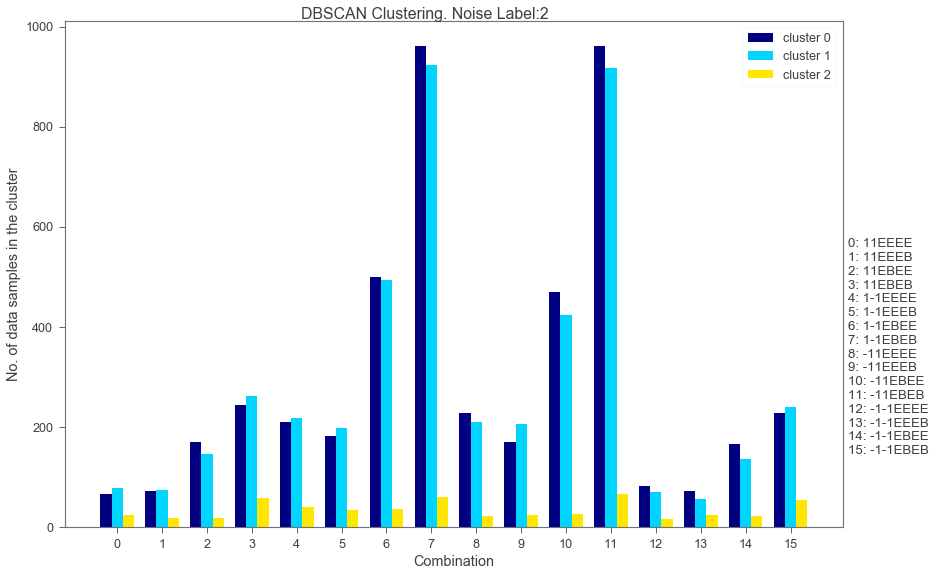

In [161]:
barplot_func_v2(training_data=train_data, pred_val=clust_labels, n_clusters=3, encoder_charge=encoded_charge, encoder_type=encoded_type,
               title='DBSCAN Clustering. Noise Label:2')

    * The main charge/type combinations in both the clusters are 7 and 11, and 6 and 10. These correspond to types (EB, EB) and (EB, EE) respectively.
    
    * Since the clustering results did not use the charge and type values, the above observation suggests that the detected values are influenced by the type of the charges, i.e. EB and EE, the meanings of which I do not know.
    
    * The combinations 0,1,12 and 13 seem to have high percentage of outliers which contain same type of charges and types (EE,EE) and (EE, EB) in the decay.